In [3]:
import cv2
import os
import numpy as np
from UNet import UNet
from sklearn.model_selection import train_test_split
from skimage.restoration import denoise_nl_means, estimate_sigma

import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model


In [4]:
def leer_imagenes(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

In [5]:
def convertir_a_grises(images):
    gray_images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images]
    return gray_images


In [6]:
from skimage.restoration import denoise_nl_means, estimate_sigma

def aplicar_filtro_anisotropico(images):
    filtered_images = []
    for image in images:
        sigma_est = np.mean(estimate_sigma(image))
        denoised = denoise_nl_means(image, h=1.15 * sigma_est, fast_mode=True,
                                    patch_size=5, patch_distance=6)
        filtered_images.append(denoised)
    return filtered_images



In [7]:
def extract_patches(images, filtered_images, patch_size=32, num_patches=500000):
    xi, yi = [], []
    total_patches_per_image = num_patches // len(images)
    
    for img, filt_img in zip(images, filtered_images):
        count = 0
        while count < total_patches_per_image:
            i = np.random.randint(0, img.shape[0] - patch_size)
            j = np.random.randint(0, img.shape[1] - patch_size)
            xi.append(img[i:i+patch_size, j:j+patch_size])
            yi.append(filt_img[i:i+patch_size, j:j+patch_size])
            count += 1
    
    return np.array(xi), np.array(yi)

In [8]:
def main(folder='test', k=32):
    images = leer_imagenes(folder)
    gray_images = convertir_a_grises(images)
    filtered_images = aplicar_filtro_anisotropico(gray_images)
    xi, yi = extract_patches(gray_images, filtered_images, patch_size=32)

    return xi, yi


xi, yi  = main()
xi_train, xi_test, yi_train, yi_test = train_test_split(xi, yi, test_size=0.2)

print(f"xi shape: {xi.shape}, yi shape: {yi.shape}")
print(f"Train shapes - xi: {xi_train.shape}, yi: {yi_train.shape}")
print(f"Test shapes - xi: {xi_test.shape}, yi: {yi_test.shape}")

xi shape: (500000, 32, 32), yi shape: (500000, 32, 32)
Train shapes - xi: (400000, 32, 32), yi: (400000, 32, 32)
Test shapes - xi: (100000, 32, 32), yi: (100000, 32, 32)


In [6]:
def unet_model(input_size=(32, 32, 1)):
    inputs = Input(input_size)

    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)

    up1 = UpSampling2D(size=(2, 2))(conv2)
    merge1 = concatenate([conv1, up1], axis=3)

    conv3 = Conv2D(32, 3, activation='relu', padding='same')(merge1)
    conv4 = Conv2D(1, 1, activation='sigmoid')(conv3)

    model = Model(inputs=inputs, outputs=conv4)

    return model


model = unet_model()
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.fit(xi_train.reshape(-1, 32, 32, 1), yi_train.reshape(-1, 32, 32, 1), epochs=15, batch_size=64, validation_split=0.1)

xi shape: (500000, 32, 32), yi shape: (500000, 32, 32)
Train shapes - xi: (400000, 32, 32), yi: (400000, 32, 32)
Test shapes - xi: (100000, 32, 32), yi: (100000, 32, 32)
Epoch 1/15
5625/5625 [==============================] - 955s 170ms/step - loss: 0.2258 - accuracy: 8.6806e-08 - val_loss: 0.2251 - val_accuracy: 0.0000e+00
Epoch 2/15
5625/5625 [==============================] - 925s 164ms/step - loss: 0.2258 - accuracy: 0.0000e+00 - val_loss: 0.2251 - val_accuracy: 0.0000e+00
Epoch 3/15
5625/5625 [==============================] - 990s 176ms/step - loss: 0.2258 - accuracy: 0.0000e+00 - val_loss: 0.2251 - val_accuracy: 0.0000e+00
Epoch 4/15
5625/5625 [==============================] - 1009s 179ms/step - loss: 0.0210 - accuracy: 0.0027 - val_loss: 6.3480e-04 - val_accuracy: 0.0033
Epoch 5/15
5625/5625 [==============================] - 1009s 179ms/step - loss: 6.4035e-04 - accuracy: 0.0030 - val_loss: 6.7846e-04 - val_accuracy: 0.0033
Epoch 6/15
5625/5625 [==============================

In [8]:
model.save('mi_modelo2212.h5')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
# Cargar el modelo
model = load_model('mi_modelo2.h5')


In [10]:
predictions = model.predict(xi_test.reshape(-1, 32, 32, 1))

3125/3125 [==============================] - 58s 18ms/step


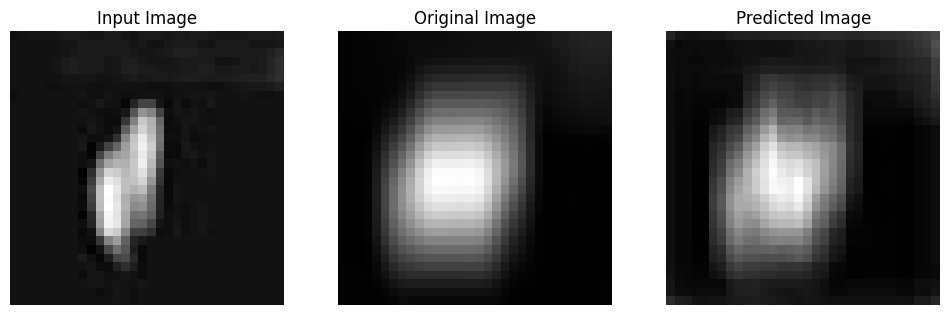

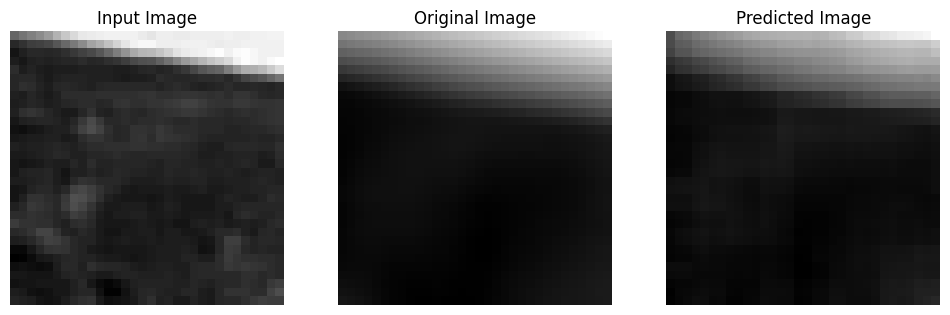

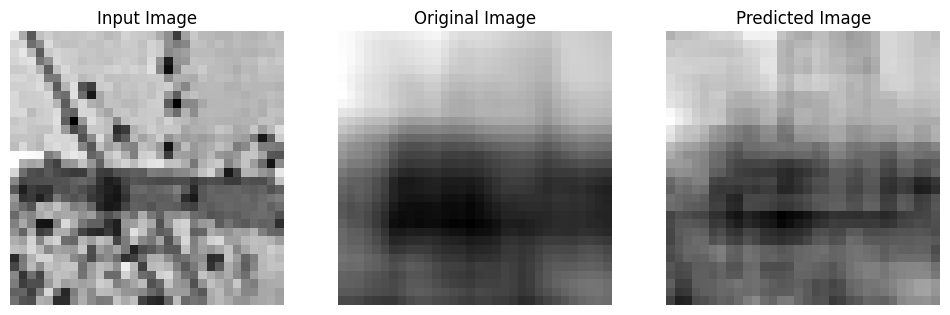

In [14]:
import matplotlib.pyplot as plt

num_images = 3
indices = np.random.choice(len(xi_test), num_images, replace=False)

for i in indices:
    plt.figure(figsize=(12, 4))

    # Imagen de entrada
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(xi_test[i], cmap='gray')
    plt.axis('off')

    # Imagen original
    plt.subplot(1, 3, 2)
    plt.title("Original Image")
    plt.imshow(yi_test[i], cmap='gray')
    plt.axis('off')

    # Predicción del modelo
    plt.subplot(1, 3, 3)
    plt.title("Predicted Image")
    plt.imshow(predictions[i].reshape(32, 32), cmap='gray')
    plt.axis('off')

    plt.show()